In [1]:
from fileinput import filename

from utils import *

# Load data
This loads results data from the results folder

In [2]:
RESULTS_FOLDER = 'simulations_run_20250319_153640'

# RESULTS_FOLDER = os.path.join('..', 'output', RESULTS_FOLDER)
RESULTS_FOLDER = os.path.join(RESULTS_FOLDER)

RESULTS_FOLDER, GRAPHS_FOLDER, dict_specs, epm_input, epm_results, mapping_gen_fuel = process_simulation_results(
    RESULTS_FOLDER, SCENARIOS_RENAME=None, folder='')

pInterconUtilizationExt not in epm_results.keys().
AdditiononalCapacity_trans not in epm_results.keys().
InterconUtilizationExt not in epm_results.keys().
pInterchangeExt not in epm_results.keys().
pHourlyFlow not in epm_results.keys().
pFuelDispatch not in epm_results.keys().
InterchangeExt not in epm_results.keys().
pNPVByYear not in epm_results.keys().
pCurtailedVRET not in epm_results.keys().
Interchange not in epm_results.keys().
pPlantFuelDispatch not in epm_results.keys().
interchanges not in epm_results.keys().
InterconUtilization not in epm_results.keys().
pCurtailedStoHY not in epm_results.keys().
annual_line_capa not in epm_results.keys().
pFuelDispatch not found in epm_dict
pPlantFuelDispatch not found in epm_dict


## Create geographical zone data
Update `geojson_to_epm.csv` in `postprocessing/static/` to define zones.

**Required Columns**:
- **Geojson**: Zone name (must match `countries.geojson`).
- **EPM**: Corresponding zone name in the EPM model.

**Optional (for country subdivisions)**:
- **region**: North, South, East, or West.
- **country**: Country name (must match `countries.geojson`).
- **division**: `'NS'` (North-South) or `'EW'` (East-West).

**Example**:
| Geojson                                  | EPM          | region | country | division |
|------------------------------------------|--------------|--------|--------|----------|
| South Africa                             | South_Africa |        |        |          |
| Namibia                                  | Namibia      |        |        |          |
| Democratic Republic of the Congo - North | DRC          | north  | Democratic Republic of the Congo     | NS       |
| Democratic Republic of the Congo - South | DRC_South    | south  | Democratic Republic of the Congo     | NS       |

Democratic Republic of the Congo is split into North/South; other zones remain the same.

In [3]:
zone_map, geojson_to_epm = get_json_data(epm_results, dict_specs)

epm_to_geojson = {v: k for k, v in geojson_to_epm.items()}  # Reverse dictionary

zone_map, centers = create_zonemap(zone_map, map_geojson_to_epm=geojson_to_epm)

# Maps

## Capacity mix

### Maps plots

/Users/celia/Documents/WorldBank/Energy_planning/EPM/epm/postprocessing/utils.py:2573: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  region_sizes['area'] = region_sizes.geometry.area


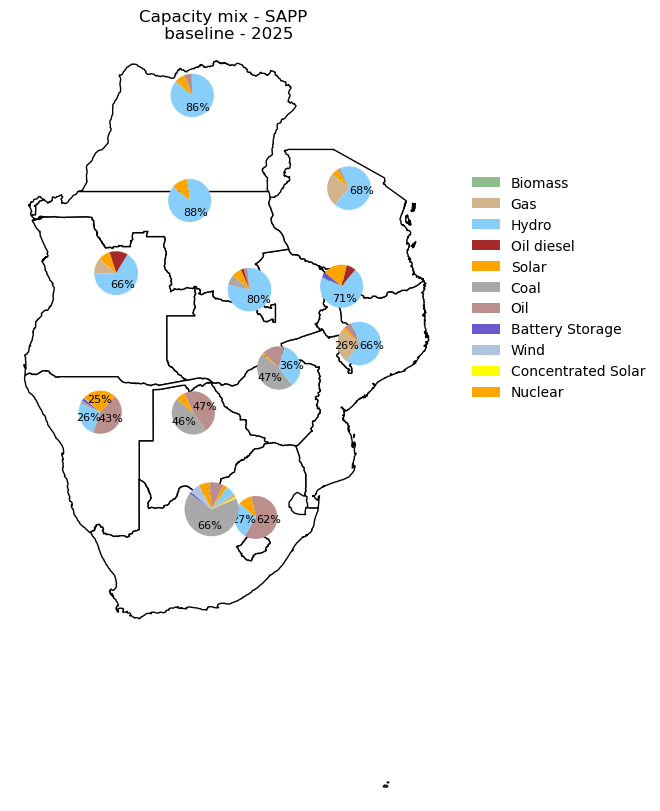

In [7]:
pCapacityByFuel = epm_results['pCapacityByFuel'].copy()
pCapacityByFuel = pCapacityByFuel.loc[pCapacityByFuel.zone.isin(list(geojson_to_epm.values()))]
make_capacity_mix_map(zone_map, pCapacityByFuel, dict_specs['colors'], centers, year=2025, region='SAPP', scenario='baseline', filename=None,
                      map_epm_to_geojson=geojson_to_epm, figsize=(12,8), bbox_to_anchor=(0.7, 0.5), loc='center left', 
                      pie_sizing=True,  min_size=1.5, max_size=4)


### Stacked bar plots

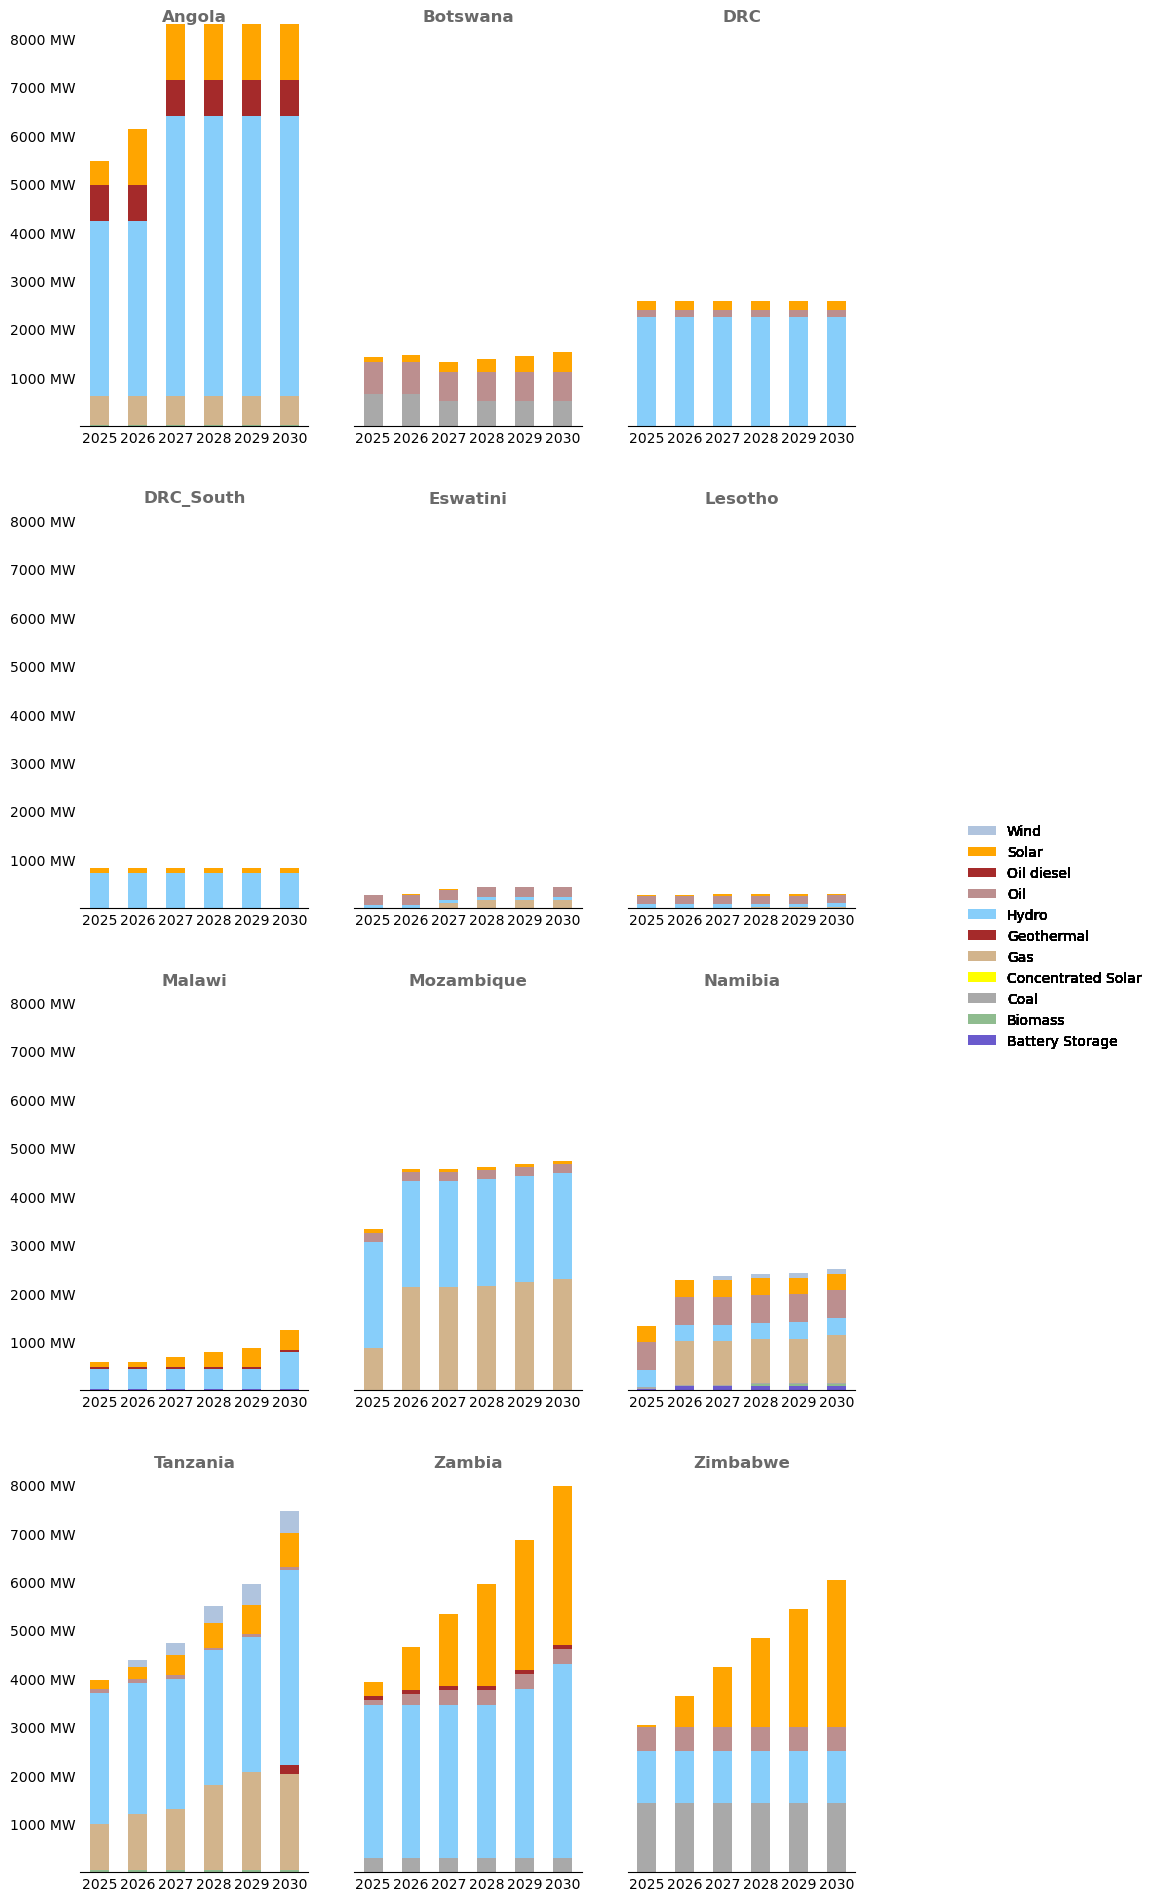

In [8]:
df = epm_results['pCapacityByFuel'].copy()

df = df.loc[df.zone != 'South_Africa']  # removing South Africa for scaling
filename = None 

make_stacked_bar_subplots(df, filename, dict_specs['colors'], selected_zone=None, selected_year=None, column_xaxis='zone',
                          column_stacked='fuel', column_multiple_bars='year',
                          column_value='value', select_xaxis=None, dict_grouping=None, order_scenarios=None, dict_scenarios=None,
                          format_y=lambda y, _: '{:.0f} MW'.format(y), order_stacked=None, cap=2, annotate=False,
                          show_total=False, fonttick=12, rotation=0, title=None)

### Stacked area plot

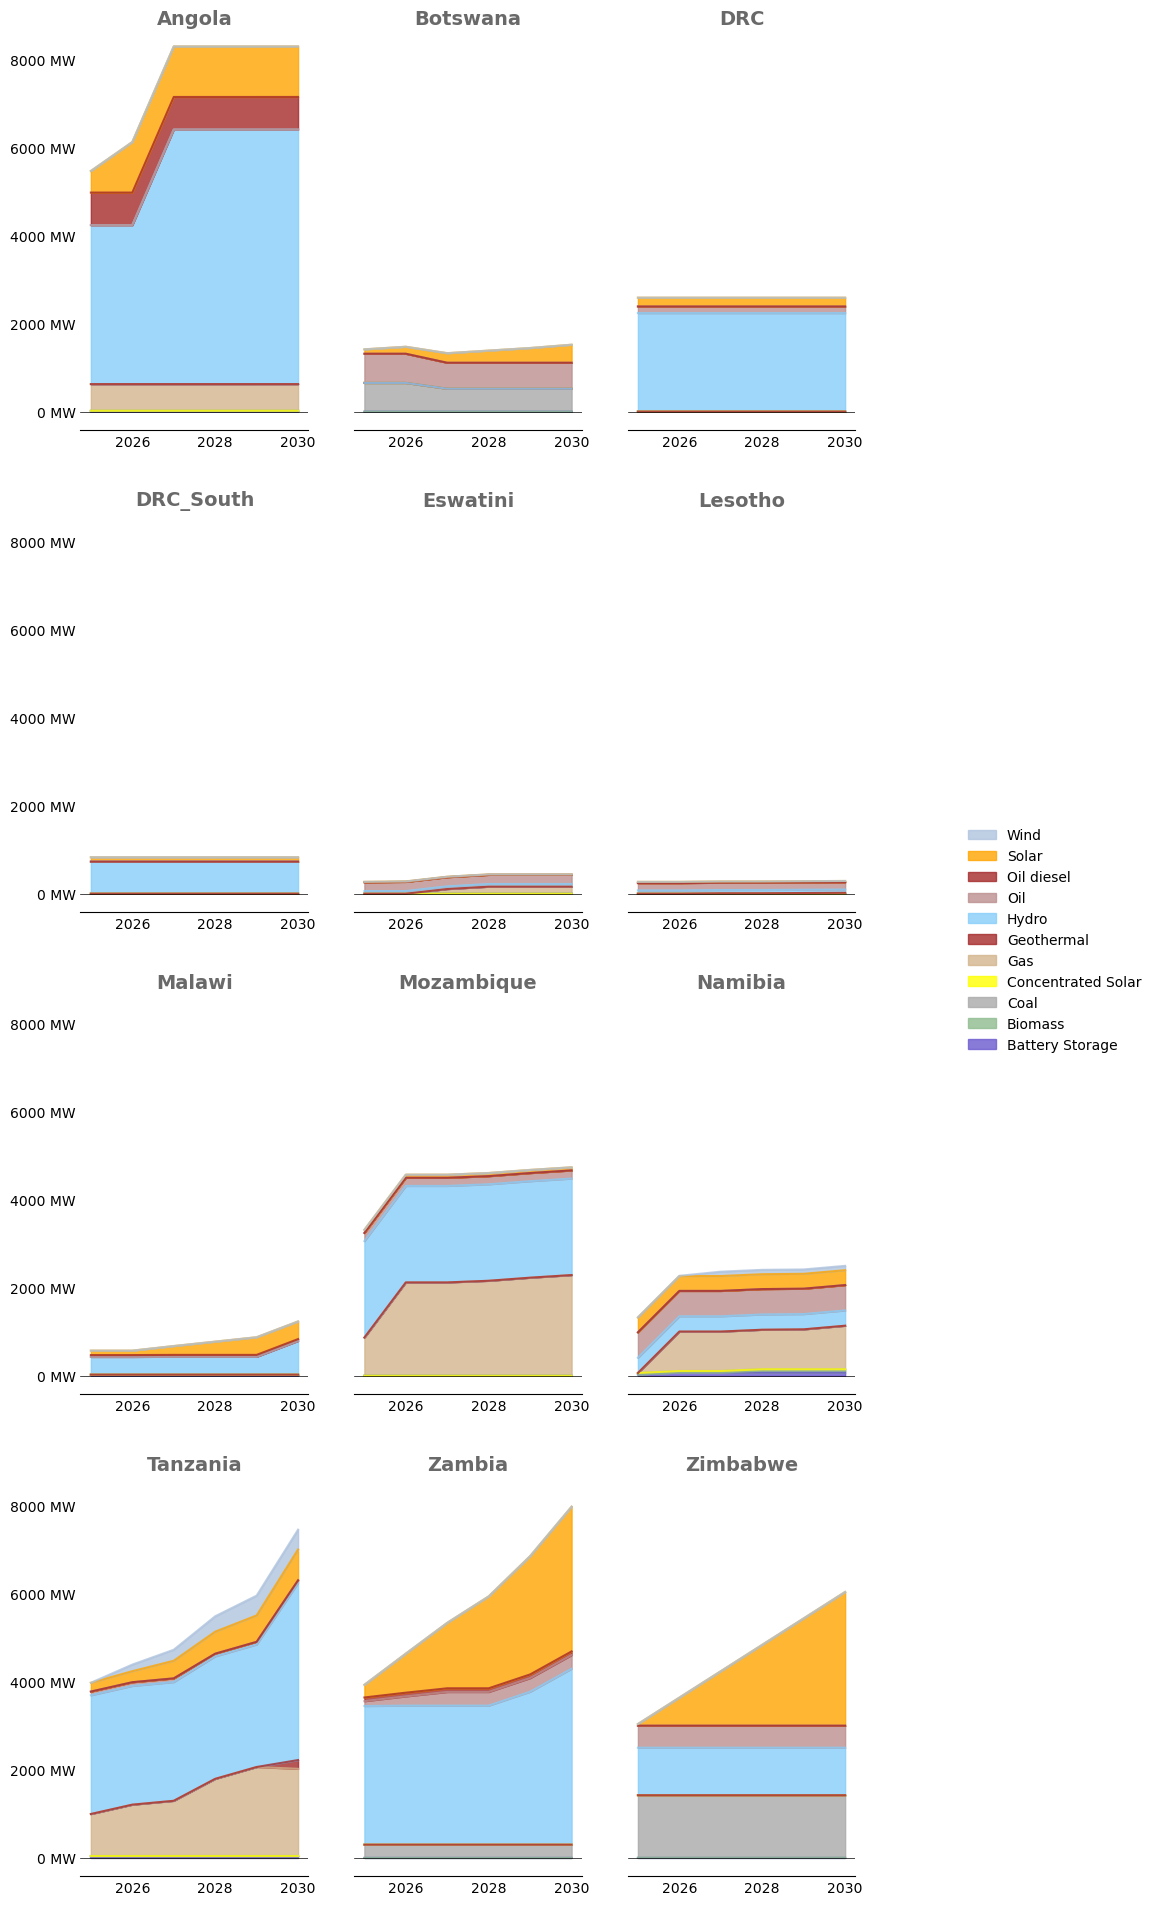

In [9]:
df = epm_results['pCapacityByFuel'].copy()

df = df.loc[df.zone != 'South_Africa']  # removing South Africa for scaling

filename = None
make_stacked_area_subplots(df, filename, dict_specs['colors'], selected_zone=None, selected_year=None, selected_scenario='baseline', column_xaxis='year',
                              column_stacked='fuel', column_subplots='zone', format_y=lambda y, _: '{:.0f} MW'.format(y),
                              column_value='value', select_xaxis=None, rotation=0)

## Transmission lines

Parameters which the user can adapt:
- `scenario`: choice of scenario to plot
- `year`: choice of year to display
- `show_labels`: whether to show country names or not

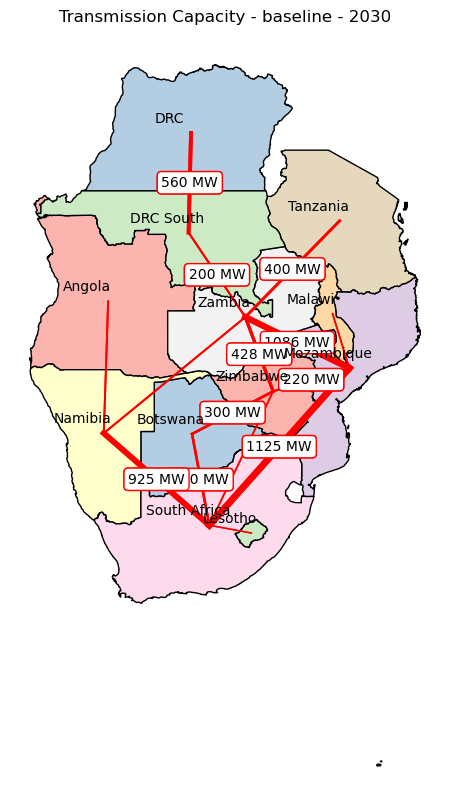

In [9]:
pAnnualTransmissionCapacity = epm_results['pAnnualTransmissionCapacity'].copy()
make_interconnection_map(zone_map, pAnnualTransmissionCapacity, centers, year=2030, scenario='baseline', label_yoffset=0.01, label_xoffset=-0.05,
                         label_fontsize=10, show_labels=True, min_display_capacity=200)


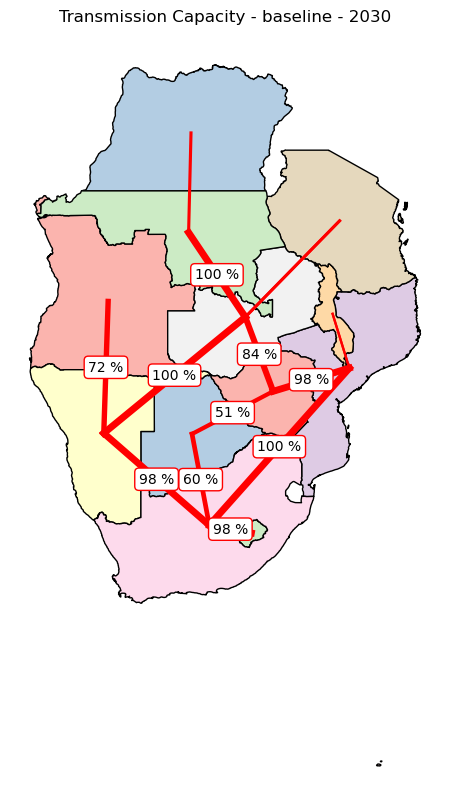

In [10]:
pInterconUtilization = epm_results['pInterconUtilization'].copy()
pInterconUtilization['value'] = pInterconUtilization['value'] * 100
make_interconnection_map(zone_map, pInterconUtilization, centers, year=2030, scenario='baseline', min_capacity=0.01, label_yoffset=0.01, label_xoffset=-0.05,
                         label_fontsize=10, show_labels=False, min_display_capacity=50, format_y=lambda y, _: '{:.0f} %'.format(y))


## Interactive map
Creates an interactive map in `html` format

In [12]:
# Preprocess transmission data
capa_transmission = epm_results['pAnnualTransmissionCapacity'].copy()
utilization_transmission = epm_results['pInterconUtilization'].copy()
transmission_data = capa_transmission.rename(columns={'value': 'capacity'}).merge(utilization_transmission.rename(columns={'value': 'utilization'}), 
                                                                                 on=['scenario', 'zone', 'z2', 'year'])
transmission_data = transmission_data.rename(columns={'zone': 'zone_from', 'z2': 'zone_to'})


energy_data = epm_results['pDemandSupply'].copy()
pCapacityByFuel = epm_results['pCapacityByFuel'].copy()
pEnergyByFuel = epm_results['pEnergyByFuel'].copy()
pDispatch = epm_results['pDispatch'].copy()
pPlantDispatch = epm_results['pPlantDispatch'].copy()
year = 2025
scenario = 'baseline'
filename = f'{RESULTS_FOLDER}/interactivemap.html'


create_interactive_map(zone_map, centers, transmission_data, energy_data, year, scenario, filename,
                           dict_specs, pCapacityByFuel, pEnergyByFuel, pDispatch, pPlantDispatch)

Interactive map saved to ../output/simulations_run_20250319_153640/interactivemap.html


Interactive map is available [here](./_static/planning_analysis_InteractiveMap_sapp.html)
